In [6]:
import sqlalchemy
import ast
import pandas as pd
import json

In [7]:
## Used to download data from Railway
# username = 'postgres'
# password = 'ms2DxHJGPsRY0qG6zc4G'
# host_name = 'containers-us-west-150.railway.app'
# port = 7278
# db_name = 'railway'

# conn_str = 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host_name, port, db_name)
# engine = sqlalchemy.create_engine(conn_str)
# query = 'SELECT * FROM prediction;'
# data_server = pd.read_sql_query(query, engine)

In [9]:
data_server.head()

,id,observation_id,observation,proba,pred,true_class
0,108,ba91d868-9056-4402-b36e-9e71c90caec3,"{'Type': 'Person and Vehicle search', 'Date': ...",0.715158,True,1.0
1,113,278a05ef-a3d9-42e4-b0ea-65fac9c5b4fd,"{'Type': 'Person search', 'Date': '2022-01-01T...",0.446089,False,0.0
2,118,b5882d71-b142-4ff4-a387-62de28d6bead,"{'Type': 'Person search', 'Date': '2022-01-01T...",0.127540,False,0.0
3,122,c528cf17-8d8d-4271-864d-7f53219201bc,"{'Type': 'Person search', 'Date': '2022-01-01T...",0.173887,False,0.0
4,126,804a0d41-fd29-4d60-890e-9f930501301e,"{'Type': 'Person search', 'Date': '2022-01-01T...",0.462372,False,1.0


In [10]:
data_server.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4000 non-null   int64  
 1   observation_id  4000 non-null   object 
 2   observation     4000 non-null   object 
 3   proba           4000 non-null   float64
 4   pred            4000 non-null   bool   
 5   true_class      3999 non-null   float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 160.3+ KB


In [5]:
# decompose "observation" string and create a dataframe with it
list_of_dicts = []
for obs in data_server.observation:
    obs_list = obs.split(",")
    obs_dict = {}
    for item in obs_list:
        s = item.replace("{", "").replace("}", "")
        s = s.replace("nan", "None")
        d = ast.literal_eval("{" + s + "}")
        obs_dict.update(d)
    list_of_dicts.append(obs_dict)

output = pd.DataFrame(list_of_dicts)

In [6]:
output.head()

,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station
0,Person and Vehicle search,2022-01-01T03:08:37+00:00,None,52.312706,-0.225271,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,cambridgeshire
1,Person search,2022-01-01T04:29:00+00:00,True,50.625847,-3.546839,Female,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall
2,Person search,2022-01-01T05:50:23+00:00,None,51.518091,-0.078308,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london
3,Person search,2022-01-01T07:34:03+00:00,None,51.506255,-0.074901,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london
4,Person search,2022-01-01T16:43:00+00:00,False,50.725010,-3.524855,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall


In [7]:
# drop not important columns
data_server = data_server.drop(columns=['id','observation_id','observation'])

# merge output dataframe with original dataframe
df_merged = output.merge(data_server,left_index=True,right_index=True)
df_merged.head()

,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,proba,pred,true_class
0,Person and Vehicle search,2022-01-01T03:08:37+00:00,None,52.312706,-0.225271,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,cambridgeshire,0.715158,True,1.0
1,Person search,2022-01-01T04:29:00+00:00,True,50.625847,-3.546839,Female,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,0.446089,False,0.0
2,Person search,2022-01-01T05:50:23+00:00,None,51.518091,-0.078308,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.127540,False,0.0
3,Person search,2022-01-01T07:34:03+00:00,None,51.506255,-0.074901,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.173887,False,0.0
4,Person search,2022-01-01T16:43:00+00:00,False,50.725010,-3.524855,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,0.462372,False,1.0


In [8]:
# Correct Postive Preds
correct_pos = df_merged[(df_merged['pred']==True) & (df_merged['true_class']==1)]
len(correct_pos)

551

In [9]:
# Correct Postive Preds
correct_neg = df_merged[(df_merged['pred']==False) & (df_merged['true_class']==0)]
len(correct_neg)

1670

In [10]:
# Incorrect Postive Preds
incorrect_pos = df_merged[(df_merged['pred']==True) & (df_merged['true_class']==0)]
len(incorrect_pos)

1455

In [11]:
# Incorrect Negative Preds
incorrect_neg = df_merged[(df_merged['pred']==False) & (df_merged['true_class']==1)]
len(incorrect_neg)

323

In [12]:
# missing 1? prediction
551+1670+1455+323

3999

<AxesSubplot:>

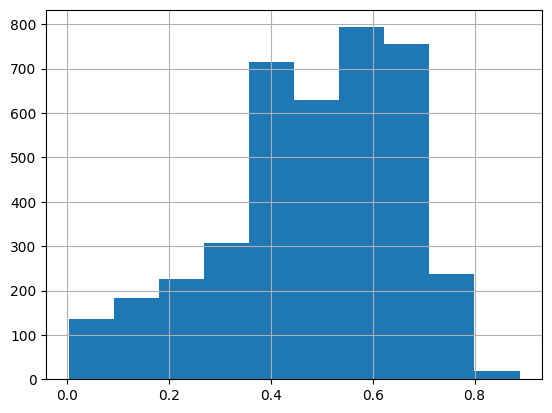

In [13]:
# distribuition of the probabilities of successful search
df_merged['proba'].hist()